In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML
from jupyter_plotly_dash import JupyterDash
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
import numpy as np
import os
from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))
from sys import exc_info
from caiman import movie as cmovie
import json
import pickle

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 1
%aimport Regions, physio_def_1, numeric, Automatic

from physio_def_1 import *
from Regions import Regions
from numeric import *
from Automatic import *

In [4]:
os.chdir(os.path.expanduser("~"))

In [5]:
# exampleNpzFile = "local_data/Sandra/2019_10_16/Experiment39a/Experiment39a_8_Series019.npz"
exampleNpzFile = "local_data/testdir/Experiment38a_18_Series040.npz"
exampleRoiFile = "local_data/srdjan_analysis/Experiment38b_11_Series041/Experiment38b_11_Series041.pkl"

In [6]:
def saveRois(regions,outDir,filename="",movie=None,col="trace",format="vienna"):
    feedback = []
    try:
        from copy import deepcopy
        from datetime import date
        import pickle
        import pandas as pd
        from os.path import isdir
        from os import makedirs
        regions.sortFromCenter()
        if movie is not None:
            regions.update(movie)
        filename = filename.replace(" ","_")
        today = date.today()
        if len(filename):
            filename = "_".join([today.strftime("%Y_%m_%d"),filename])
        else:
            filename = today.strftime("%Y_%m_%d")
        if not isdir(outDir):
            makedirs(outDir)
            feedback += f"Output {outdir} directory created."

        traces = pd.DataFrame(np.vstack(regions.df[col]).T)
        traces["time"] = regions.showTime[col]
        traces = traces[["time"]+list(traces.columns[:-1])]
        if format=="vienna":
            tracefile = f"{outDir}/{filename}_trace.csv"
            traces.to_csv(tracefile, index=False)
        elif format=="maribor":
            tracefile = f"{outDir}/{filename}_trace_for_mb.txt"
            np.savetxt(tracefile, traces.values)
        else:
            return "Output format not recognized. Currently, only 'vienna' and 'maribor' are implemented."
            
        feedback += [f"Traces saved in {tracefile}.",html.Br()]

        saving = ['statImages', 'mode', 'image', 'filterSize', 'df']
        allAttrs = list(regions.__dict__.keys())
        subRegions = deepcopy(regions)
        for k in allAttrs:
            if k not in saving:
                del subRegions.__dict__[k]
        for k in regions.df.columns:
            if k not in ["peak", "pixels"]:
                del subRegions.df[k]
                
        if format=="vienna":
            roifile = f"{outDir}/{filename}_rois.pkl"
            with open(roifile,"wb") as f:
                pickle.dump(subRegions,f)
            feedback += [f"ROI info saved in {roifile}."]
            
        if format=="maribor":
            coordFile = f"{outDir}/{filename}_coords_for_mb.txt"
            coords = np.array([np.mean(pxs,axis=0) for pxs in subRegions.df["pixels"]])
            np.savetxt(coordFile, coords)
            feedback += [f"Coordinates saved in {coordFile}."]
            
    except:
        from sys import exc_info
        feedback += ["ERROR: "+ exc_info().__repr__()]
    return feedback

In [7]:
outputStyle = {
    "color":"blue",
    "font-family":"Courier New",
    "font-size":"80%",
    "max-width": "700px",
    }
infoStyle = {
    "font-size":"70%",
    "font-family":"Arial",
    # "background-color":"lightcyan",
    "color":"grey",
    "max-width": "700px",
    }
bodyStyle = {
    "font-family":"Arial",
    "max-width": "700px",
    }

In [8]:
baseFig = getFigure(w=200,h=150)

In [9]:
## global vars
test = "srdjan" in os.getcwd()
# npzFile = None
# metadata = None
# movie = None
regions = None
debug = "srdjan" in os.getcwd()

In [10]:
if test:
    %config InlineBackend.figure_format = 'retina'

In [11]:
app = JupyterDash(__name__,
                  width=1000,
                  height=1000,
                 )

APP_LAYOUT = [
    
    html.H1(children='CaRec Analyzer',style=bodyStyle),
    html.Div("Please, think of a better name and let me know. :-)",style=infoStyle),
    html.Br(),
    ####################################
    html.Div('Enter path to a file and press enter.',style={**bodyStyle, "display":"inline-box"}),
#     html.Div('If you I will not check for movement, so if you already have a motion-corrected file, input that directly.',style={**infoStyle, "display":"inline-box"}),
    
    dcc.Input(id="filename_input",
            type="text",
            placeholder=exampleNpzFile,
            debounce=True,
            size = 60,
#             value=exampleRoiFile if test else "",
            value=exampleNpzFile if test else "",
        ),

    html.Br(),
    
    html.Div(id="filename_feedback", children="",style=outputStyle),#To start, enter the full path to a file and press enter. Note, that loading can take a few seconds [for very large files even a minute].
    
    html.Div([html.Br(),"    Re(set) Frequency to "],style={**bodyStyle,'display': 'inline-block'}),
    dcc.Input(id="freq_input",
        type="text",
        debounce=True,
        size = 5,
        value="",
        placeholder="3",
        style={'display': 'inline-block'}),    
    html.Div("Hz  ",style={**bodyStyle,'display': 'inline-block'}),
    html.Button("(Re)set frequency", n_clicks=0, id="freq_button"),

    html.Div("[use if you need override automatic setting, or in the absence of metadata]",style={**infoStyle,'display': 'inline-block'}),

    html.Div(id="freq_feedback", children="",style=outputStyle),

    html.Div(children=[html.Br(),"    Spatial filtering "],style={**bodyStyle,'display': 'inline-block'}),

    dcc.Input(id="gSig_filt_input",
        type="text",
        debounce=True,
        size = 5,
        value="",
        placeholder="3",
        style={'display': 'inline-block'}),    

    html.Div(html.Abbr(
        children="[info]",
        title="""For the proper analysis, you need to set the size of the spatial filter. Its value should be of the order of the  half of the typical cell dimension (in pixels!). 
You can also combine filtering at different scales by inputing a list of two (or more) integers. For example, '[5,3]' will combine filtering at 5 and at 3. Sometimes this capures better the finer structure.
        """
        ),style={**infoStyle,'display': 'inline-block'}),
    html.Button("Calculate ROIs", n_clicks=0, id="rois_button"),
    html.Div(id="rois_feedback", children="",style=outputStyle),

    html.Div(children="[optional] Filter",style={**bodyStyle, 'display': 'inline-block'}),
    
    dcc.Input(id="filter_input",
        type="text",
        debounce=True,
        size = 5,
        placeholder="10",
        value="",
        style={'display': 'inline-block'}),
    
    html.Div(children=" ",style={"width":"20px",'display': 'inline-block'}),
    html.Div(children=" ", id="filter_feedback",
             style={'display': 'inline-block',**outputStyle}),
    
    html.Div(style=infoStyle,
        children=[
        """
        Use this if you wish to see and/or output traces prefiltered.
        Input the time scale (in seconds) of the longest event you wish to keep (e.g. 5), and press enter.
        """,
        html.Br(),],),
    
# #     html.H3(children='ROIs', style=bodyStyle),
    
    html.Div([
        "Show downsampled to",
        dcc.Input(id="show_freq_input",
            type="text",
            debounce=False,
            size = 3,
            value='5'),
        "Hz"
        ], style={**bodyStyle,"display":"inline-block", "width":"49%"}, ),
    html.Div([
        dcc.Checklist(
            id="show_filtered_choice",
            options=[{"label":'Show filtered',"value":"yes"}],
            value=[],
            labelStyle={'vertical-align': 'bottom'},
            style={**bodyStyle,"display":"inline-box",}
            ),
        
        ]),
    html.Br(),
    html.Div(dcc.Graph(id='roi_selector',    figure=baseFig), style={"display":"inline-block"}),
    html.Div(dcc.Graph(id='show_hover_trace',figure=baseFig), style={"display":"inline-block"}),
    html.Br(),
    html.Div(children=
        html.Pre(
        id="hover_out",
        children="hover",
        style={
            "vertical-align":"top",
            "width"    : "200px",
            "height"   : "100px" if debug else "0px",
            'border'   : 'thin lightgrey solid',
            'overflowY': 'scroll',
            "display"  : "inline-box"
              }),
             style={"display":"inline-block"}),
    html.Div(children=
        html.Pre(
        id="selected_out",
        children="selected",
        style={
            "vertical-align":"top",
            "width"    : "200px",
            "height"   : "100px" if debug else "0px",
            'border'   : 'thin lightgrey solid',
            'overflowY': 'scroll',
            "display"  : "inline-box"
              }),
             style={"display":"inline-block"}),
    html.Div(children=
        html.Pre(
        id="hover_plot_out",
        children="hover plot out",
        style={
            "vertical-align":"top",
            "width"    : "200px",
            "height"   : "100px" if debug else "0px",
            'border'   : 'thin lightgrey solid',
            'overflowY': 'scroll',
            "display"  : "inline-box"
              }),
             style={"display":"inline-block"}),
    html.Div(children=
        html.Pre(
        id="spare_out",
        children="spare",
        style={
            "vertical-align":"top",
            "width"    : "200px",
            "height"   : "100px" if debug else "0px",
            'border'   : 'thin lightgrey solid',
            'overflowY': 'scroll',
            "display"  : "inline-box"
              }),
             style={"display":"inline-block"}),
    
    html.Div([
       "Selected ROIs:",
        dcc.Input(id="selected_indices",
            type="text",
            debounce=True,
            size=60,
            value="",
         ), 
        html.Button('Discard unselected', id='discard_button', style={"display":"inline-box"},
                    n_clicks=0
                   ),
        html.Div(id="discard_feedback",children="",
             style={"display":"inline-box",**outputStyle,
#                     "width":100
                   }
            )
    ],style={**bodyStyle,"display":"inline-box"}),
    
    
    html.Div([
    html.Button('Plot selected', id='plot_selected_button', style={"display":"inline-box"},
                n_clicks=0
               ),
        html.Div("... with offset: ", style={**bodyStyle,"display":"inline-block"}),
        html.Div(dcc.Input(id="offset_input",
            type="text",
            debounce=False,
            size=3,
            value='1'), style={**bodyStyle,"display":"inline-block"}),
        html.Div("(only when showing filtered)", style={**infoStyle,"display":"inline-block"}),
    ]),
    
    
    html.Div(dcc.Graph(id='show_selected_traces',figure=getFigure(h=10,w=700))),
    

#     # html.Div([
#     #     "Save tag to selected rois: ",
#     #     dcc.Input(id="tag_save",
#     #         type="text",
#     #         debounce=False,
#     #         size = 30,
#     #         placeholder="e.g. beta, alpha, edge, central...",
#     #         value=''),
#     #     html.Div("save_tag_feedback",style=outputStyle,id="save_tag_feedback"),
#     # ]),
    
    
    html.H3("Save all"),
    html.Div([
        "When you are happy with your analysis, you can save it. By default, the analysis (traces and coordinates) is saved as the current date (e.g. 2020_02_18) in the directory",
        html.Div("",style=outputStyle,id="analysis_folder"),
        "You can modify the filename by adding to it some other identifier(s) by entering them in the input box below. I suggest your username.",
        "When you are ready, press save."
        "Note also that the traces and times will be saved with the frequency close (yet not necessarily the same) to the one given in the field 'Show downsampled'. "
    ]),
    dcc.Input(id="save_file_append",
        type="text",
        debounce=False,
        size = 30,
        placeholder="e.g. username",
        value='',style={"display":"inline-box"}),
    html.Button('Save', id='save_button', style={"display":"inline-box"},
                n_clicks=0
               ),
    html.Div(id="save_feedback",
             style={"display":"inline-box",**outputStyle}
            )
    ]

# test=False

In [12]:
@app.callback([Output("filename_feedback", "children"),
               Output("gSig_filt_input", "value"),
               Output("freq_input", "value"),
               Output("analysis_folder","children")
              ],
              [Input("filename_input", "value")],
#               [State("check_movement_choice","value")]
             )
def loadFiles(val):
    if str(val)=="":
        return ('Loading can take a some time [for very large files even minutes].',"","","")
    try:
        from pandas import read_csv
        global regions, movie
        npzFile = val
        if val.endswith(".npz"):
            analysisFolder = npzFile.replace(".npz","_analysis")
            if not test:
                reimport = True
            else:
                try:
                    movie.fr
                    reimport = False
                except:
                    reimport = True
            if reimport:
                movie = import_npz_files([npzFile])
                movie = movie.astype("float")
                if len(movie.shape)==2:        
                    movie = movie.reshape((1,-1))
                movie = cmovie(movie)
                
            timeframes = len(movie)
            feedback = [
                f"{npzFile} loaded successfully.",
                html.Br(),
            ]
                

            try:
                metadata = read_csv(npzFile.replace("npz","txt")).loc[0]
#                 if not hasattr(metadata,"freq"):
#                     metadata.freq = 1
                movie.fr = metadata.freq
                timeframes = metadata['T']
                assert timeframes==len(movie)
                freq = metadata.freq
                pxsize = metadata.pxSize
                
                feedback += [
                    f"Info from metadata: frequency {freq:.4} Hz, and pixel size {pxsize:.3} µm.",
                html.Br(),
                ]
                outFilterSize = str(int(np.ceil(6./pxsize)))
                feedback += [
                    f"Automatic size of the spatial filter based on the pixel size: {outFilterSize} [you can change it below]",
                    html.Br(),]
            except:
                feedback += [
                    f"WARNING: Missing medatada. I will assume a frequncy of 1Hz for the first setup.",
                    "In case you actually know the frequency, you can change it down."
                    "Also, think carefully about the size of the spatial filter. See hover info.",
                html.Br(),
                ]
                outFilterSize = None
                freq = 1
                
            movie.fr = freq
                

            # resample temporarily to lower frequency, to initiate ROIs and check for motion correction
            if freq>3:

                freqMC = 3
                n_rebin = int(movie.fr/freqMC)

                rebinned_movie = rebin(movie,n_rebin).astype("float32")
                rebinned_movie = cmovie(rebinned_movie)
                rebinned_movie.fr = movie.fr/n_rebin
            else:
                rebinned_movie = movie.astype("float32")

            # initiate ROIs
#             regions = createRegions(rebinned_movie, gSig_filt=None, full=False, mode="diff_std", dr)
            regions = Regions(rebinned_movie, full=False, diag=True)
            del regions.statImages["diff_mean"]
            regions.movie = movie
            regions.file = val
            try: regions.metadata = metadata
            except: pass
            

            return (feedback, outFilterSize,str(freq), analysisFolder)
        
        if val.endswith(".roi") or val.endswith(".pkl"):
            if test:
                try: regions.time
                except:
                    with open(val,"rb") as f:
                        regions = pickle.load(f)
            else:
                with open(val,"rb") as f:
                    regions = pickle.load(f)
                    
            freq = 1/np.diff(regions.time).mean()
            regions.movie.fr = freq
            regions.file = val
            feedback = [f"Roi file imported successfully. The movie dimensions (T,X,Y) are {regions.movie.shape}, and the frequency is {freq:.1f}Hz. This means the duration of the recording is {regions.movie.shape[0]/freq:.1f}s."]
            feedback += [html.Br(), f"The file was saved with the filter size(s): {regions.filterSize}"]
            filterOut = str(regions.filterSize).replace(" ",",")
            freqOut = "%.1f"%freq
            analysisFolder = os.path.split(val)[0]+"/"
            return (feedback, filterOut, freqOut, analysisFolder)
            
    except:
        return ([html.P("ERROR: "+exc_info().__repr__())], "", "", "")

In [13]:
@app.callback(
    Output("freq_feedback", "children"),
    [Input("freq_button", "n_clicks")],
    [State("freq_input", "value")]
             )
def resetFreq_callback(n_clicks,newfreq):

    try:
        if n_clicks <= 0:
            return ""
        else:
            global regions
            newFreq = float(newfreq)
            regions.time = np.arange(len(regions.movie))/newFreq
            regions.movie.fr = newFreq
            return "Movie frequency set to %.1f Hz"%newFreq
    except:
            return "ERROR: "+exc_info().__repr__()

In [14]:
@app.callback([
    Output("rois_feedback", "children"),
    Output("roi_selector","figure")
    ],
    [Input("rois_button", "n_clicks")],
    [State("gSig_filt_input", "value")]
             )
def rois_callback(n_clicks,val):

    try:
        if n_clicks <= 0:
            return "", baseFig
        else:
            global regions
        x = eval(val)
        if type(x) == int:
            x = [x]
        feedback = []
        if not hasattr(regions, "filterSize") or sorted(regions.filterSize) != sorted(x):
            feedback += [f"Size of the spatial filter changed to {x}.",html.Br()]
            regions.constructRois(regions.statImages[regions.mode], gSig_filt=x, diag=True)
            # merge obvious ROIs
            from Regions import getPeak2BoundaryDF, getGraph_of_ROIs_to_Merge, mergeBasedOnGraph
            while True:
                peak2bnd = getPeak2BoundaryDF(regions.df)
                df = peak2bnd.query("dist<1.")[["i","j"]]
                if len(df)==0: break
                gRois = getGraph_of_ROIs_to_Merge(df,regions,plot=False)
                dropped = mergeBasedOnGraph(gRois,regions)
                if dropped == 0: break

            regions.purge_lones((min(x)*.5)**2)
            regions.sortFromCenter()
        
            
        feedback += [f" Number of ROIs: {len(regions.df)}"]
        im = regions.statImages["diff_std"]
        roisImage = showRoisOnly(regions,indices=regions.df.index,im=im)

#         roisImage.update_layout({"width":220,"height":240})
#         aspectRatio = im[1]/im[0]
        
        return feedback, roisImage

    except:
            return "ERROR: "+exc_info().__repr__(), baseFig

In [15]:
@app.callback(
    Output("selected_out", "children"),
    [Input("roi_selector", "selectedData")],
    )
def showSelected(selData):
    try:
        return json.dumps(selData, indent=2)
    except:
        return "ERROR from hover: "+exc_info().__repr__() 

@app.callback(
    Output("selected_indices", "value"),
    [Input("roi_selector", "selectedData")]
)
def collectSelected(selData):
    try:
        out = np.unique([pt["hovertext"] for pt in selData["points"]])
        out = sorted(out,key=int)
        return ", ".join(out)
    except:
        return "" 

In [16]:


@app.callback(
#      Output("roi_selector", "figure"),
     Output("discard_feedback", "children"),
    [Input("discard_button",   "n_clicks")],
    [State("selected_indices", "value")]
             )
def discard_callback(n_clicks,selected):
    try:
        if n_clicks <= 0:
            return ""

        global regions
        if selected == "":
            out = "nothing selected."
        else:
            selectedIndices = np.array(list(eval(selected)))
            nremoved = len(regions.df)-len(selectedIndices)
            regions.df = regions.df.loc[selectedIndices]
            out = "%i rois removed. Please, press again the button to 'Calculate Rois', to replot the remaining rois."%(nremoved)

#         roisImage = showRoisOnly(regions,indices=regions.df.index,im=regions.statImages["diff_std"])
#         if narrowHover:
#             roisImage.update_layout({"width":220,"height":240})
        return out
    except:
        return "ERROR: "+exc_info().__repr__()

In [17]:
@app.callback(
    [Output("show_hover_trace", "figure"),
     Output("hover_plot_out", "children")],
    [Input("roi_selector", "hoverData")],
    [State("show_freq_input", "value"),
     State("show_filtered_choice", "value"),])
def plotHovered_callback(hoverData, showFreq, showFiltered):
    try:
        global regions
        showFreq = float(showFreq)
        filtered = bool(len(showFiltered))
        colToshow = parseCol(regions, showFreq, filtered)
        showCol = [colToshow]
        #if filtered:
            #try: showCol += [colToshow+"_slow"]
            #except: pass
        try:
            hoverData.dtype
            ix = hoverData
        except:
            ix = [int(hoverData["points"][0]["hovertext"])]

        trfig = plotTraces(regions,indices=ix,time=regions.showTime[colToshow], showCol=showCol)
#         if narrowHover:
#         trfig.update_layout({"width":220,"height":200})
        return trfig,"ok "
    except:
        return baseFig,"ERROR from plotHovered_callback: "+exc_info().__repr__() 

In [18]:
def parseCol(regions, showFreq, filtered):
    if not hasattr(regions,"time"):
        regions.calcTraces(movie)
    if "trace" not in regions.df:
        regions.calcTraces(movie)
    if filtered:
        col = "showFilteredTrace_%.1f"%showFreq
        col0 = "filteredTrace"
    else:
        col = "showTrace_%.1f"%showFreq
        col0 = "trace"
    regions.df[col0]
    if not hasattr(regions,"showTime"):
        print ('creating empty showTime.')
        regions.showTime = {}
    if col not in regions.df.columns:
        n_Avg = int(regions.movie.fr/showFreq)
        n_Avg = max(1,n_Avg)
        if n_Avg<=1:
            regions.showTime[col] = regions.time
            regions.df[col] = regions.df[col0]
        else:
            print ('creating',col)
            regions.showTime[col] = rebin(regions.time,n_Avg)
            regions.df[col] = list(np.ones((len(regions.df),len(regions.showTime[col]))))
            #if filtered:
                #regions.df[col+"_slow"] = list(np.ones((len(regions.df),len(regions.showTime[col]))))
            for i in regions.df.index:
                if i==0:
                    print ("filling in", col)
                regions.df[col].loc[i] = rebin(regions.df.loc[i,col0],n_Avg)
                #regions.df[col+"_slow"].loc[i] = rebin(regions.df.loc[i,col0+"_slow"],n_Avg)
    return col

In [19]:
@app.callback(
    Output("filter_feedback", "children"),
    [Input("filter_input", "value")]
             )
def filter_callback(val):
    try:
        if val == "":
            feedback = ""
        else:
            global regions
            timeScale = float(val)
            filterSize = int(timeScale*regions.movie.fr)
            if filterSize<10:
                return f"Filer size would need to be {filterSize}. This is too short time scale. I cannot work like this! :-P"
            feedback = "You chose to discard all time structure longer than %g seconds."%timeScale
            if filterSize<20:
                feedback = " This a rather short time scale, can't guarantee for the results."
            if "faster_%g"%timeScale not in regions.df:
                regions.filter_traces(timeScale,percentile = [10,10], calcStd=False)
            regions.df["filteredTrace"] = regions.df["faster_%g"%timeScale]
            regions.df["filteredTrace_slow"] = regions.df["faster_%g"%timeScale]
            for col in regions.df.columns:
                if "show" in col:
                    del regions.df[col]
            feedback += " Filtering successful."
        return feedback
    except:
        return "ERROR: "+exc_info().__repr__()
    

In [20]:
@app.callback(
    [Output("show_selected_traces", "figure"),
     Output("spare_out", "children"),
    ],
    [Input("plot_selected_button", "n_clicks")],
    [State("selected_indices", "value"),
     State("show_freq_input", "value"),
     State("show_filtered_choice", "value"),
     State("offset_input", "value"),],)
def plotTraces_callback(n_clicks, chosen, showFreq, showFiltered, offset, forceOffset=False):
    try:
        if n_clicks<=0 or chosen=="":
            return baseFig,"waiting"
        global regions,movie
        showFreq = float(showFreq)
        filtered = bool(len(showFiltered))
        if forceOffset:
            offset = float(offset)
        else:
            offset = float(offset) if filtered else 0
        colToshow = parseCol(regions, showFreq, filtered)
        if chosen=="":
            return baseFig, "nothing yet"
        try:
            ix = np.array(chosen.strip(" ,").split(","))
            ix = ix.astype(int)
            trfig = plotTraces(regions,indices=ix,time=regions.showTime[colToshow], showCol=[colToshow], offset=offset)
            trfig.update_layout({"width":800,"height":200+50*np.log(4*len(ix))})
            return trfig,"ok: "+repr((chosen, showFreq, showFiltered, offset))
        except:
            return baseFig,"error in chosen parsing"+repr(chosen)
    except:
        return baseFig,"ERROR from plotTraces_callback: "+exc_info().__repr__() 

In [21]:
@app.callback(
    Output("hover_out", "children"),
    [Input("roi_selector", "hoverData")],
    )
def showHovered(hoverData):
    try:
        return json.dumps(hoverData, indent=2)
    except:
        return "ERROR from hover: "+exc_info().__repr__() 



In [22]:
@app.callback(
    Output("save_feedback", "children"),
    [Input("save_button", "n_clicks")],
    [State("save_file_append", "value"   ),
     State("show_freq_input", "value"),
     State("analysis_folder","children")
    ]
             )
def save_callback(n_clicks,filename, showFreq, outDir):

    try:
        if n_clicks <= 0:
            return "saving can take a few seconds."
        else:
            global regions
#             filename = regions.file
#             if filename.endswith("roi") or filename.endswith("pkl"):
#                 outDir = os.path.split(filename)[0]
#             else:
#                 ext = filename.split(".")[1]
#                 outDir = filename.replace("."+ext,"_analysis")
            
            return saveRois(regions, outDir, filename, format="maribor", col=parseCol(regions, float(showFreq), True))
    except:
            return "ERROR: "+exc_info().__repr__()

In [23]:
# app.layout = html.Div(children=APP_LAYOUT)
# app

In [24]:
app.layout = html.Div(children=APP_LAYOUT)
app._repr_html_() 
link2app = "https://ctn.physiologie.meduniwien.ac.at"+app.get_app_root_url()
HTML(f'open the following link in a different tab (do not close this tab!): <a href="{link2app}">{link2app}</a>')

In [30]:
exampleNpzFile

'local_data/testdir/Experiment38a_18_Series040.npz'

In [32]:
dd = np.loadtxt("local_data/Sandra/2019_10_16/Experiment39a/Experiment39a_8_Series019_analysis/2020_04_23_marjan_test_trace_for_mb.txt")

In [38]:
signal = dd[:-1,1:len(dd[0])]

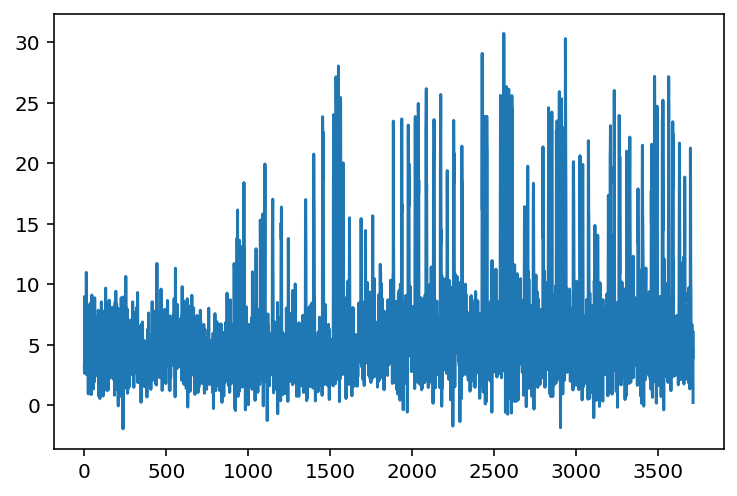

In [41]:
plt.plot(signal.T[1])

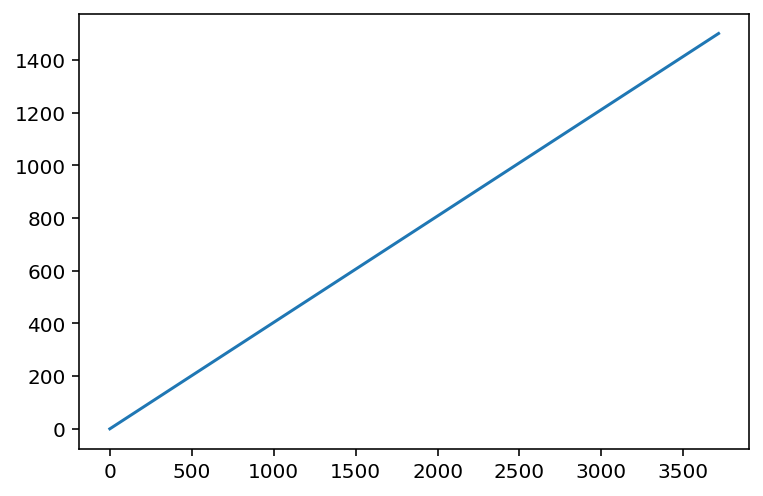

In [36]:
plt.plot(dd[:-1,0])